# Advanced Retrieval for AI with Chroma
by DeepLearning.AI

In [1]:
from pypdf import PdfReader
from pprint import pprint

reader = PdfReader(".\chroma_storage\cdn-dynmedia-1.microsoft.com.pdf")
pdf_texts = [p.extract_text().strip() for p in reader.pages]

# Filter the empty strings
pdf_texts = [text for text in pdf_texts if text]

print(pdf_texts[0])

<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\c'
C:\Users\fredr\AppData\Local\Temp\ipykernel_12008\1030811321.py:4: SyntaxWarning: invalid escape sequence '\c'
  reader = PdfReader(".\chroma_storage\cdn-dynmedia-1.microsoft.com.pdf")


1 
Dear shareholders, colleagues, customers, and partners: 
Fiscal year 2024 was a pivotal year for Microsoft. We entered our 50th year as a company and the second year of the AI 
platform shift. With these milestones, I’ve found myself reflecting on how Microsoft has remained a consequential company 
decade after decade in an industry with no franchise value. And I realize that it’s because—time and time again, when tech 
paradigms have shifted —we have seized the opportunity to reinvent ourselves to stay relevant to our customers, our 
partners, and our employees. And that’s what we are doing again today.  
Microsoft has been a platform and tools company from the start. We were founded in 1975 with a belief in creating 
technology that would enable others to create their own. And, nearly 50 years later, this belief remains at the heart of our 
mission to empower every person and every organization on the planet to achieve more.  
This year, we moved from talking about AI to helping o

**Chunking these pages by Characters and Tokens**

In [2]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter

In [3]:
character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],   # Perference from first to last, splits based on \n\n first as chunks with max chunk size.
    chunk_size=1000,                # If chunk size gets more than 1000, it splits THAT chunk based on \n, and so on.
    chunk_overlap=0
)
character_split_texts = character_splitter.split_text("\n\n".join(pdf_texts))    # Split the whole file.

print("The 10th chunk:\n", character_split_texts[10])
print(f"\nTotal chunks: {len(character_split_texts)}")

The 10th chunk:
 3 
staying in their flow and bringing the joy back to coding. This year, we also introduced Copilot Workspace, a Copilot-native 
developer environment, which helps any developer go from idea, to code, to software—all in natural language.  
We are also integrating generative AI across Power Platform, enabling anyone to use natural language to create apps, 
automate workflows, or build a website. In total, we now have 48  million monthly active users of Power Platform, up 
40 percent year-over-year.  
Modern work  
Microsoft 365 Copilot is becoming a daily habit for knowledge workers, transforming their work, workflow, and work artifacts. 
Adoption has been faster than any other new Microsoft 365 suite. And employees at nearly 60  percent of the Fortune 500 
now use Copilot to complete tasks faster, hold more effective meetings, and automate business workflows and processes.

Total chunks: 342


In [4]:
token_splitter = SentenceTransformersTokenTextSplitter(
    chunk_overlap=0,
    tokens_per_chunk=256    # Context Window length of the SentenceTransformerEmbeddingModel
)

token_split_texts = []
for text in character_split_texts:
    token_split_texts +=token_splitter.split_text(text)

pprint(f"The 10th chunk:\n{token_split_texts[10]}", width=150)
print(f"\nTotal chunks: {len(character_split_texts)}")

('The 10th chunk:\n'
 '3 staying in their flow and bringing the joy back to coding. this year, we also introduced copilot workspace, a copilot - native developer '
 'environment, which helps any developer go from idea, to code, to software — all in natural language. we are also integrating generative ai across '
 'power platform, enabling anyone to use natural language to create apps, automate workflows, or build a website. in total, we now have 48 million '
 'monthly active users of power platform, up 40 percent year - over - year. modern work microsoft 365 copilot is becoming a daily habit for '
 'knowledge workers, transforming their work, workflow, and work artifacts. adoption has been faster than any other new microsoft 365 suite. and '
 'employees at nearly 60 percent of the fortune 500 now use copilot to complete tasks faster, hold more effective meetings, and automate business '
 'workflows and processes.')

Total chunks: 342


**Load chunks to Chroma**

In [5]:
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()
print(embedding_function([token_split_texts[10]]))

[array([-7.16159940e-02, -3.28083150e-02,  1.37579702e-02,  7.91877741e-04,
        3.34563926e-02, -7.69314356e-03,  2.78001633e-02,  5.27220033e-03,
        6.70649018e-03, -1.63349696e-02, -6.50985166e-02,  6.27579066e-05,
       -2.28739493e-02,  1.39710521e-02,  1.23192325e-01,  1.04662664e-01,
        1.33002345e-02, -8.84125754e-02, -1.78203208e-03, -6.06858097e-02,
       -3.33663039e-02, -8.00382160e-03, -1.39239831e-02, -1.57964993e-02,
        3.73077504e-02,  2.88191792e-02, -8.10246989e-02, -5.41279055e-02,
        6.50319830e-02,  2.74751079e-03, -7.52384514e-02,  7.96751678e-02,
        6.57480210e-02,  9.62239057e-02,  6.73095742e-03,  4.74736318e-02,
        1.18506942e-02,  4.03765701e-02, -5.42807393e-03, -6.85792491e-02,
       -3.73591743e-02, -3.53258699e-02, -1.71703212e-02,  3.49534601e-02,
        5.58741614e-02, -4.24483046e-02, -5.43240868e-02,  1.04429210e-02,
        3.09926365e-02,  9.08052325e-02, -6.71224818e-02, -9.28946808e-02,
        5.77814840e-02, 

In [6]:
chroma_client = chromadb.Client()
chroma_collection = chroma_client.create_collection(
    "microsoft_annual_report_2024",
    embedding_function=embedding_function
)

ids = [str(i) for i in range(len(token_split_texts))]

chroma_collection.add(
    ids=ids,
    documents=token_split_texts
)
print(f"Total count in the '{chroma_collection.name}' collection: {chroma_collection.count()}")

Total count in the 'microsoft_annual_report_2024' collection: 354


**Querying/Searching and Retrieving Documents**

In [7]:
from pprint import pprint
query = "What was the total revenue?"

results = chroma_collection.query(
    query_texts=[query],
    n_results=5
)
retrieved_documents = results['documents'][0]

for document in retrieved_documents:
    pprint(document, width=140)
    print('\n')

('72 note 13 — unearned revenue unearned revenue by segment was as follows : ( in millions ) june 30, 2024 2023 productivity and business '
 'processes $ 30, 879 $ 27, 572 intelligent cloud 23, 117 21, 563 more personal computing 6, 188 4, 678 total $ 60, 184 $ 53, 813 changes '
 'in unearned revenue were as follows : ( in millions ) year ended june 30, 2024 balance, beginning of period $ 53, 813 deferral of '
 'revenue 148, 701 recognition of unearned revenue ( 142, 330 ) balance, end of period $ 60, 184 revenue allocated to remaining '
 'performance obligations, which includes unearned revenue and amounts that will be invoiced and recognized as revenue in future periods, '
 'was $ 275 billion as of june 30, 2024, of which $ 269 billion is related to the commercial portion of revenue. we expect to recognize '
 'approximately 45 % of our total company remaining')


('80 no sales to an individual customer or country other than the united states accounted for more than 10 % of revenue fo

**Connect an LLM and building a RAG System**

In [8]:
import os
import openai
from openai import OpenAI   # OpenAI's client
from groq import Groq
from dotenv import load_dotenv
load_dotenv()

groq_client = Groq()

In [9]:
def rag(query, retrieved_documents, model = "llama-3.3-70b-versatile"):
    information = "\n\n".join(retrieved_documents)

    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Your users are asking questions about information contained in an annual report."
            "You will be shown the user's question, and the relevant information from the annual report. Answer the user's question using only this information."
        },
        {
            "role": "user",
            "content": f"Question: {query}. \nInformation: {information}"
        }
    ]

    response = groq_client.chat.completions.create(
        model=model,
        messages=messages
    )

    return response.choices[0].message.content

In [10]:
query = "What was the total revenue?"

output = rag(
    query=query,
    retrieved_documents=retrieved_documents
)

pprint(output, width=140)

'The total revenue was $245,122 million for the year ended June 30, 2024.'


# Pitfalls of Retrieval
when simple vector search 

In [11]:
embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = chroma_client.get_collection(name="microsoft_annual_report_2024")
chroma_collection.count()

354

In [12]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from umap import UMAP

In [13]:
embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = UMAP(random_state=2049, transform_seed=2049, n_jobs=-1).fit(embeddings)

c:\Users\fredr\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [14]:
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings), 2))
    for i, embedding in enumerate(tqdm(embeddings)):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings

project_dataset_embeddings = project_embeddings(embeddings, umap_transform)

100%|██████████| 354/354 [00:06<00:00, 53.01it/s] 


(np.float64(1.4751417875289916),
 np.float64(13.455329155921936),
 np.float64(4.763342666625976),
 np.float64(10.817240905761718))

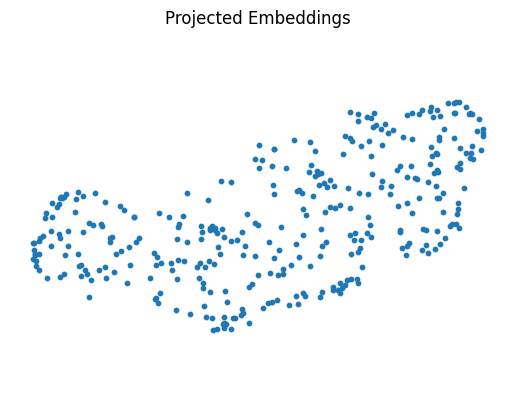

In [15]:
plt.figure()
plt.scatter(project_dataset_embeddings[:, 0], project_dataset_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off')

**Relevancy and Distraction**

In [16]:
results = chroma_collection.query(
    query_texts=query,
    n_results=5,
    include=['documents', 'embeddings']
)
retrieved_documents = results['documents'][0]
for doc in retrieved_documents:
    pprint(doc, width=150)
    print()

('72 note 13 — unearned revenue unearned revenue by segment was as follows : ( in millions ) june 30, 2024 2023 productivity and business processes '
 '$ 30, 879 $ 27, 572 intelligent cloud 23, 117 21, 563 more personal computing 6, 188 4, 678 total $ 60, 184 $ 53, 813 changes in unearned revenue '
 'were as follows : ( in millions ) year ended june 30, 2024 balance, beginning of period $ 53, 813 deferral of revenue 148, 701 recognition of '
 'unearned revenue ( 142, 330 ) balance, end of period $ 60, 184 revenue allocated to remaining performance obligations, which includes unearned '
 'revenue and amounts that will be invoiced and recognized as revenue in future periods, was $ 275 billion as of june 30, 2024, of which $ 269 '
 'billion is related to the commercial portion of revenue. we expect to recognize approximately 45 % of our total company remaining')

('80 no sales to an individual customer or country other than the united states accounted for more than 10 % of revenue for fis

In [ ]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

project_query_embeddings = project_embeddings([query_embedding], umap_transform)
project_retrieved_embeddings = project_embeddings([retrieved_embeddings], umap_transform)

In [ ]:
plt.figure()
plt.scatter(project_dataset_embeddings[:, 0], project_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_dataset_embeddings[:, 0], project_query_embeddings[0], s=150, marker='X', colorizer='r')
plt.scatter(project_dataset_embeddings[:, 0], project_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')


plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')